# Vizualiation of predicitons 

## Predictions of the top performing models according the dominance analysis and scpm ranking

### Random Forest - Top model according to the SCPM of -3.64

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "203",
    "Plant": "C",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/203/c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.776 (0.146)
MAE: -0.600 (0.121)
MAPE: -0.014 (0.003)
R2: 0.982 (0.007)


******
[TEST]
******
RMSE: -0.877 (0.192)
MAE: -0.658 (0.154)
MAPE: -0.015 (0.003)
R2: 0.977 (0.009)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2017-08-01 15:36:00,49.03,47.316630,TRAIN,CP II-F40
1,2017-08-02 15:41:00,46.93,47.153145,TRAIN,CP II-F40
2,2017-08-02 15:41:00,33.20,34.414155,TRAIN,CP II-E32
3,2017-08-04 15:41:00,46.80,47.344420,TRAIN,CP II-F40
4,2017-08-04 15:41:00,34.40,34.414155,TRAIN,CP II-E32
...,...,...,...,...,...
2820,2023-03-27 11:00:00,47.06,47.362229,TEST,CP VARI
2821,2023-03-27 11:00:00,33.21,33.579855,TEST,CP II-E32
2822,2023-03-28 11:01:00,33.28,33.666554,TEST,CP II-E32
2823,2023-03-28 11:01:00,47.11,46.311113,TEST,CP II-E40


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_random_forest_btsscv_209_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_random_forest_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

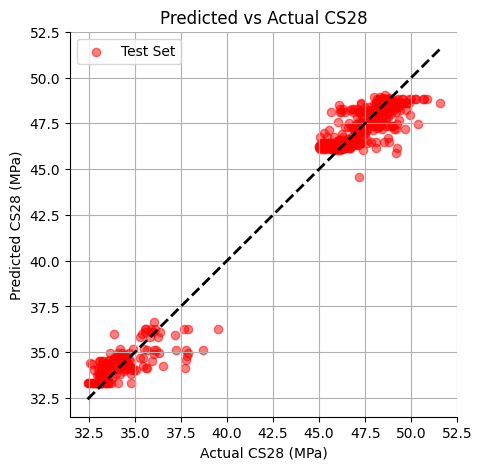

<IPython.core.display.Javascript object>

In [15]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_203_c_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



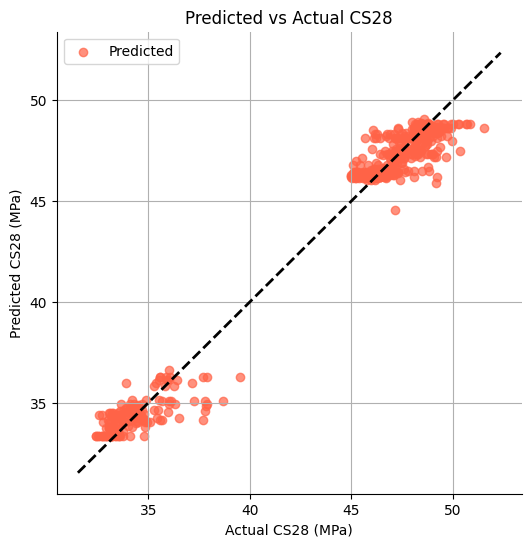

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [df_pred["CS28"].min(), df_pred["CS28"].max()],
    [df_pred["CS28"].min(), df_pred["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_203_c_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
df["Cement_Type"].value_counts()

Cement_Type
CP VARI      870
CP II-E32    801
CP II-F40    628
CP II-E40    530
Name: count, dtype: int64

<IPython.core.display.Javascript object>

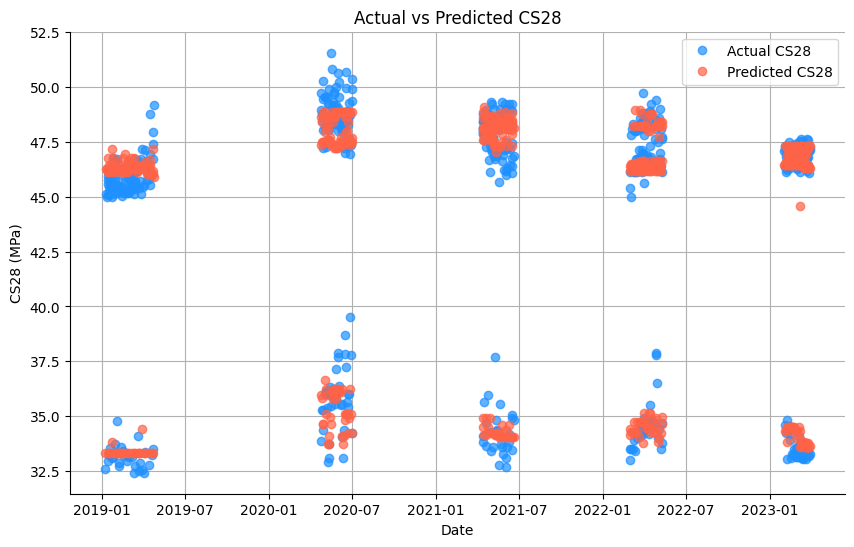

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [19]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [20]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Importances - 0,0.000000,0.000000,0.000000,0.001950,0.000512,0.000163,0.00000,0.000000,0.000170,0.000858,0.000141,0.975715,0.000000,0.000440,0.000000,0.000000,0.000000,0.000009,0.020043
Importances - 1,0.000230,0.000000,0.000000,0.000000,0.000826,0.000493,0.00000,0.000000,0.000000,0.001442,0.000945,0.773504,0.001705,0.001040,0.003026,0.000359,0.008421,0.001540,0.206470
Importances - 2,0.000629,0.000706,0.000734,0.000482,0.000612,0.001850,0.00000,0.001237,0.000000,0.000000,0.002604,0.393904,0.000000,0.000226,0.000000,0.000000,0.398053,0.001484,0.197480
Importances - 3,0.000379,0.000000,0.000121,0.000299,0.000655,0.000267,0.00000,0.000000,0.000667,0.000236,0.000000,0.195026,0.000000,0.000000,0.000301,0.000000,0.002435,0.392605,0.407010
Importances - 4,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.00071,0.000000,0.000077,0.000288,0.000000,0.197854,0.000000,0.395889,0.000000,0.000026,0.203142,0.002519,0.199443


<IPython.core.display.Javascript object>

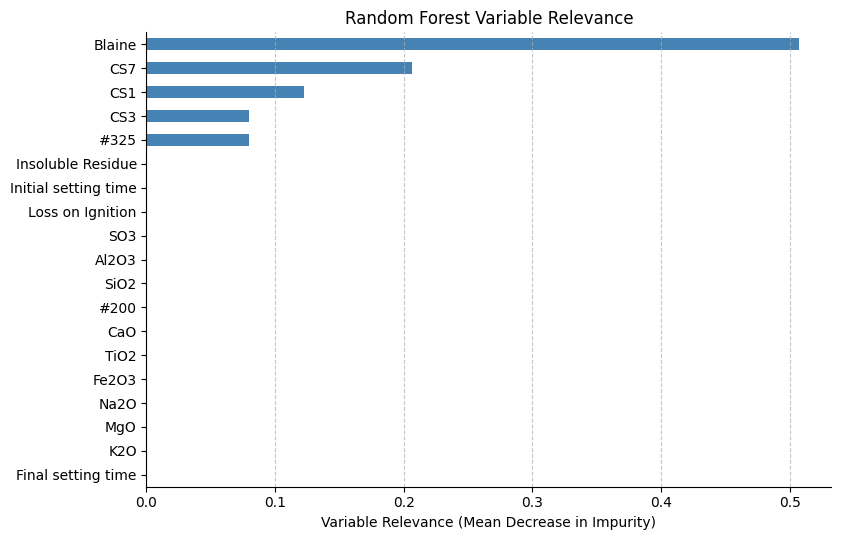

<IPython.core.display.Javascript object>

In [21]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

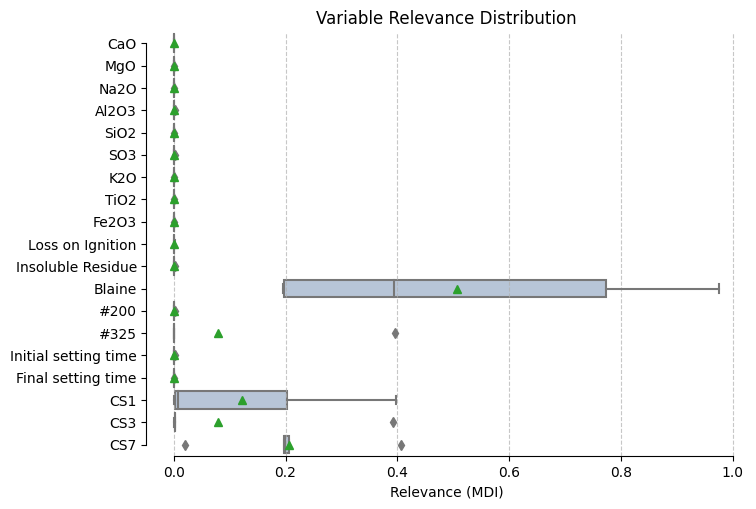

<IPython.core.display.Javascript object>

In [22]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


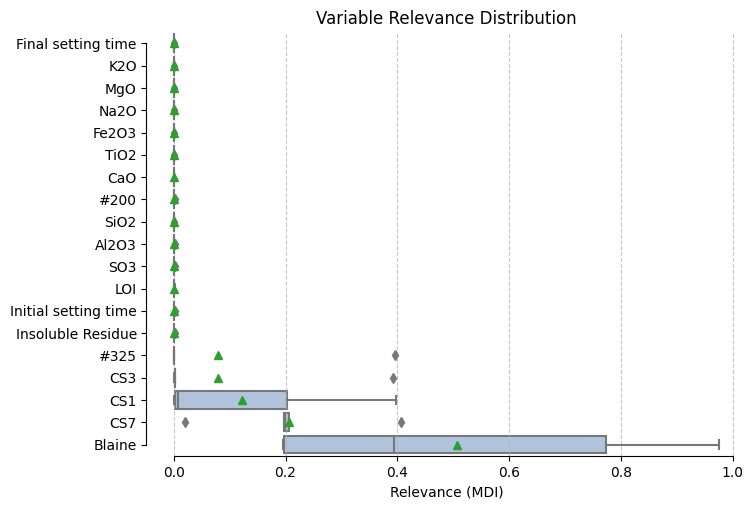

<IPython.core.display.Javascript object>

In [23]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_203_c_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


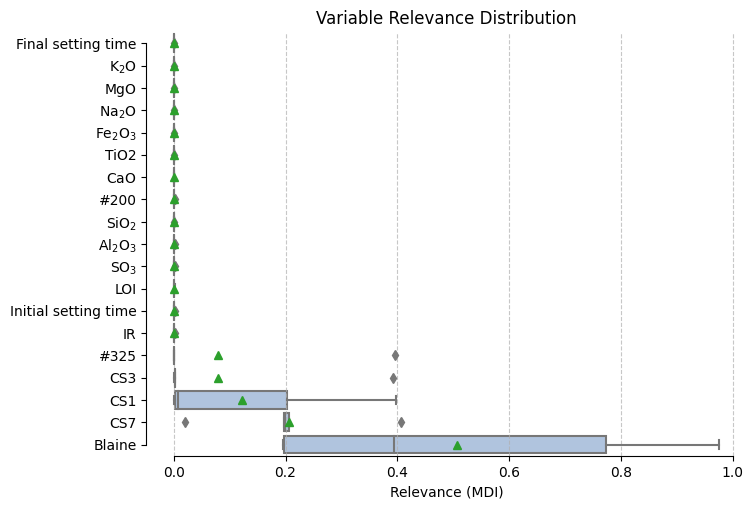

<IPython.core.display.Javascript object>

In [24]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [25]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Importances - 0,0.000000,0.000000,0.000000,0.001950,0.000512,0.000163,0.00000,0.000000,0.000170,0.000858,0.000141,0.975715,0.000000,0.000440,0.000000,0.000000,0.000000,0.000009,0.020043
Importances - 1,0.000230,0.000000,0.000000,0.000000,0.000826,0.000493,0.00000,0.000000,0.000000,0.001442,0.000945,0.773504,0.001705,0.001040,0.003026,0.000359,0.008421,0.001540,0.206470
Importances - 2,0.000629,0.000706,0.000734,0.000482,0.000612,0.001850,0.00000,0.001237,0.000000,0.000000,0.002604,0.393904,0.000000,0.000226,0.000000,0.000000,0.398053,0.001484,0.197480
Importances - 3,0.000379,0.000000,0.000121,0.000299,0.000655,0.000267,0.00000,0.000000,0.000667,0.000236,0.000000,0.195026,0.000000,0.000000,0.000301,0.000000,0.002435,0.392605,0.407010
Importances - 4,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.00071,0.000000,0.000077,0.000288,0.000000,0.197854,0.000000,0.395889,0.000000,0.000026,0.203142,0.002519,0.199443


<IPython.core.display.Javascript object>

In [26]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.000247,0.000267,0.000000,0.000000,0.000230,0.000379,0.000629
MgO,5.0,0.000152,0.000311,0.000000,0.000000,0.000000,0.000052,0.000706
Na2O,5.0,0.000171,0.000319,0.000000,0.000000,0.000000,0.000121,0.000734
Al2O3,5.0,0.000546,0.000811,0.000000,0.000000,0.000299,0.000482,0.001950
SiO2,5.0,0.000521,0.000312,0.000000,0.000512,0.000612,0.000655,0.000826
SO3,5.0,0.000554,0.000746,0.000000,0.000163,0.000267,0.000493,0.001850
K2O,5.0,0.000142,0.000317,0.000000,0.000000,0.000000,0.000000,0.000710
TiO2,5.0,0.000247,0.000553,0.000000,0.000000,0.000000,0.000000,0.001237
Fe2O3,5.0,0.000183,0.000279,0.000000,0.000000,0.000077,0.000170,0.000667
Loss on Ignition,5.0,0.000565,0.000583,0.000000,0.000236,0.000288,0.000858,0.001442


<IPython.core.display.Javascript object>

In [27]:
df_importances.mean(axis=0)

CaO                     0.000247
MgO                     0.000152
Na2O                    0.000171
Al2O3                   0.000546
SiO2                    0.000521
SO3                     0.000554
K2O                     0.000142
TiO2                    0.000247
Fe2O3                   0.000183
Loss on Ignition        0.000565
Insoluble Residue       0.000738
Blaine                  0.507201
#200                    0.000341
#325                    0.079519
Initial setting time    0.000665
Final setting time      0.000077
CS1                     0.122410
CS3                     0.079631
CS7                     0.206089
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
df_importances.std(axis=0, ddof=0)

CaO                     0.000239
MgO                     0.000278
Na2O                    0.000286
Al2O3                   0.000726
SiO2                    0.000279
SO3                     0.000667
K2O                     0.000284
TiO2                    0.000495
Fe2O3                   0.000250
Loss on Ignition        0.000521
Insoluble Residue       0.000997
Blaine                  0.315090
#200                    0.000682
#325                    0.158186
Initial setting time    0.001186
Final setting time      0.000141
CS1                     0.158031
CS3                     0.156489
CS7                     0.122557
dtype: float64

<IPython.core.display.Javascript object>

In [29]:
df_copy.nunique()

Date                    1515
CaO                      973
MgO                      326
Na2O                      48
Al2O3                    315
SiO2                     850
SO3                      235
K2O                      109
TiO2                      41
Fe2O3                    186
Loss on Ignition         494
Insoluble Residue        294
Blaine                   185
#200                     204
#325                     533
Initial setting time      31
Final setting time        48
CS1                     1191
CS3                     1134
CS7                     1011
dtype: int64

<IPython.core.display.Javascript object>

In [30]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [31]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [32]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

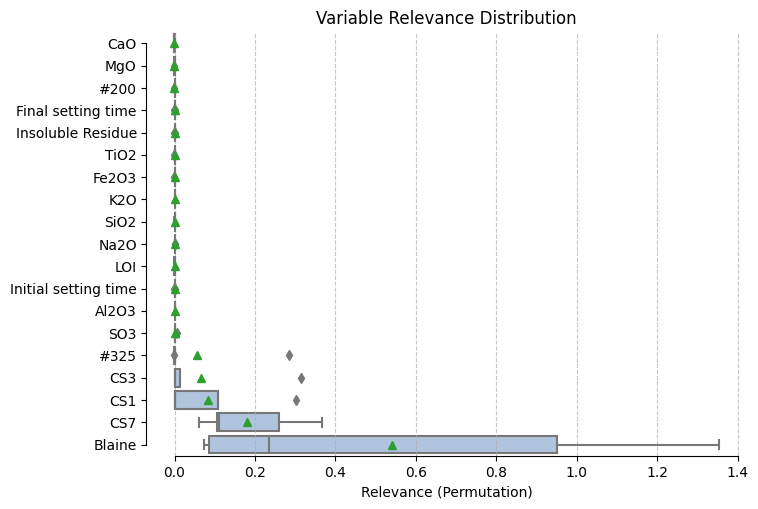

<IPython.core.display.Javascript object>

In [33]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

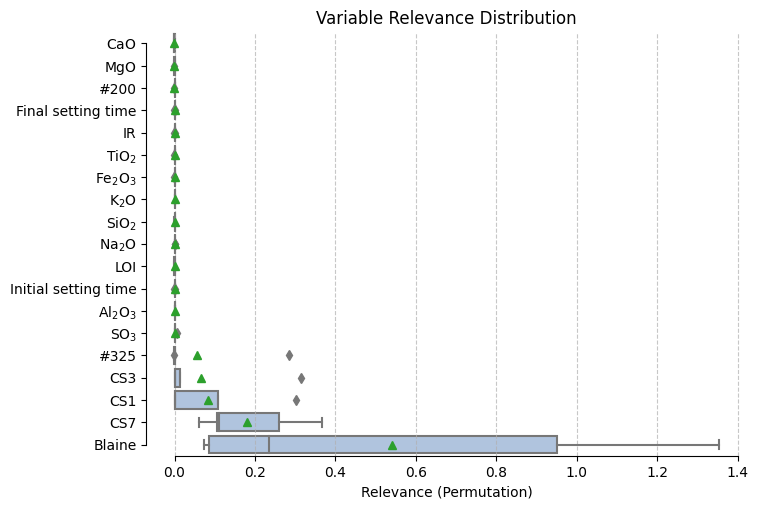

<IPython.core.display.Javascript object>

In [34]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [35]:
perm_importances_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
MgO,5.0,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
#200,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Final setting time,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Insoluble Residue,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
TiO2,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Fe2O3,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
K2O,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SiO2,5.0,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Na2O,5.0,0.00,0.00,-0.00,0.00,0.00,0.00,0.00


<IPython.core.display.Javascript object>

In [36]:
perm_importances_df

,CaO,MgO,#200,Final setting time,Insoluble Residue,TiO2,Fe2O3,K2O,SiO2,Na2O,LOI,Initial setting time,Al2O3,SO3,#325,CS3,CS1,CS7,Blaine
0,0.000000,0.000000,0.00000,0.000000,-0.001135,0.000000,0.000000,0.0,0.000003,0.000000,-0.000349,0.000000,0.000956,0.000132,-0.000523,0.000000,0.000000,0.259321,1.354202
1,-0.000942,0.000000,-0.00089,-0.000583,0.000000,0.000000,0.000000,0.0,0.000188,0.000000,0.000476,0.001976,0.000000,-0.000067,-0.001994,0.000021,0.002353,0.109792,0.951683
2,-0.000475,-0.000872,0.00000,0.000000,0.000630,-0.000277,0.000000,0.0,0.000209,-0.000035,0.000000,0.000000,0.001137,0.007201,-0.000061,0.000000,0.301013,0.060990,0.234251
3,-0.000158,0.000000,0.00000,0.000000,0.000000,0.000000,-0.000117,0.0,-0.000258,0.000269,-0.000178,-0.000200,0.000767,0.000649,0.000000,0.314748,0.000508,0.365810,0.086875
4,0.000000,-0.000117,0.00000,0.000007,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000357,0.000000,0.000000,0.000000,0.285321,0.012327,0.106859,0.105432,0.073493


<IPython.core.display.Javascript object>

In [37]:
perm_importances_df.mean(axis=0)

CaO                    -0.000315
MgO                    -0.000198
#200                   -0.000178
Final setting time     -0.000115
Insoluble Residue      -0.000101
TiO2                   -0.000055
Fe2O3                  -0.000023
K2O                     0.000000
SiO2                    0.000028
Na2O                    0.000047
LOI                     0.000061
Initial setting time    0.000355
Al2O3                   0.000572
SO3                     0.001583
#325                    0.056549
CS3                     0.065419
CS1                     0.082147
CS7                     0.180269
Blaine                  0.540101
dtype: float64

<IPython.core.display.Javascript object>

In [38]:
perm_importances_df.std(axis=0, ddof=0)

CaO                     0.000358
MgO                     0.000340
#200                    0.000356
Final setting time      0.000234
Insoluble Residue       0.000571
TiO2                    0.000111
Fe2O3                   0.000047
K2O                     0.000000
SiO2                    0.000168
Na2O                    0.000112
LOI                     0.000313
Initial setting time    0.000814
Al2O3                   0.000481
SO3                     0.002820
#325                    0.114389
CS3                     0.124756
CS1                     0.116870
CS7                     0.114429
Blaine                  0.519392
dtype: float64

<IPython.core.display.Javascript object>